In [93]:
import json
import pickle
import math
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
from pathlib import Path
import matplotlib.pyplot as plt
from argparse import Namespace

import tensorflow as tf

from flowers_utils import *

AUTO = tf.data.experimental.AUTOTUNE

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 - get datasets 

### raw dataset

In [5]:
fds2 = FlowersDataSet2()

In [7]:
fds2.get_raw_dataset()

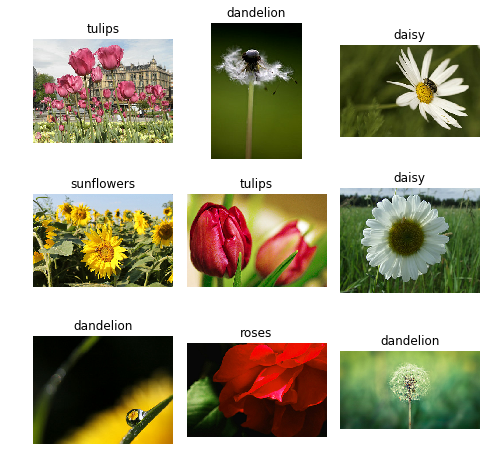

In [8]:
display_9_images_from_dataset(fds2.raw_dataset)

### resized dataset

In [9]:
fds2.get_resized_dataset()

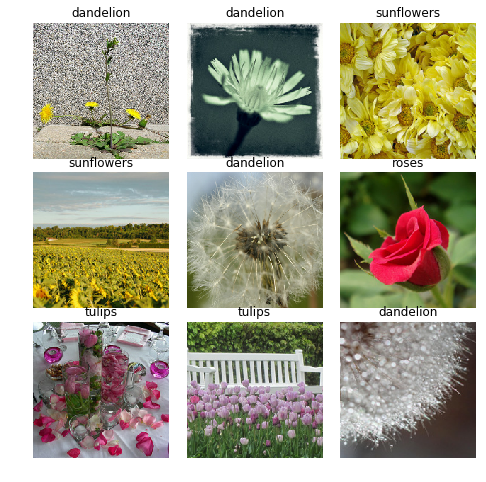

In [10]:
display_9_images_from_dataset(fds2.resized_dataset)

In [11]:
for image, label in fds2.resized_dataset.take(1):
    print(image.shape)

(192, 192, 3)


### TFRecord dataset

In [12]:
fds = FlowersDataSet()

In [17]:
fds.write_tfrecord()

===> writing TFRecords ...
tfrecords-jpeg-192x192/flowers00-230.tfrec with 230 records DONE


In [18]:
fds.read_tfrecord()

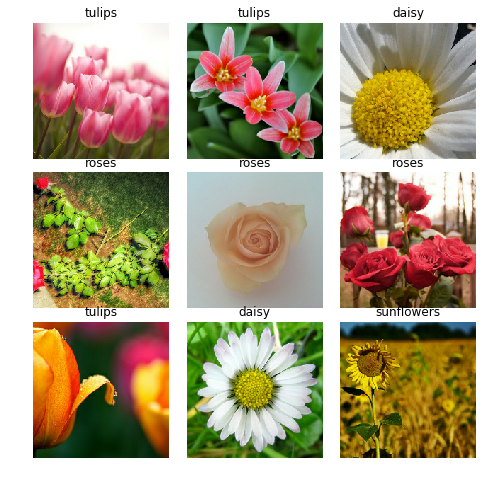

In [19]:
display_dataset = fds.dataset_from_tfr.map(lambda image, class_num: (image, class_num))
display_9_images_from_dataset(display_dataset, is_class_num=True, fds=fds)

In [20]:
for image, class_num in fds.dataset_from_tfr.take(1):
    print(image.shape, class_num)

(192, 192, 3) tf.Tensor(3, shape=(), dtype=int64)


## 2 - write datasets into GCS

In [4]:
fds = FlowersDataSetWithWriter()

In [5]:
fds.GCS_OUT_PATTERN

'gs://dl-projects-2020-bucket-1/flowers/tfrecords-jpeg-192x192/flowers'

In [6]:
fds.read_tfrecord()

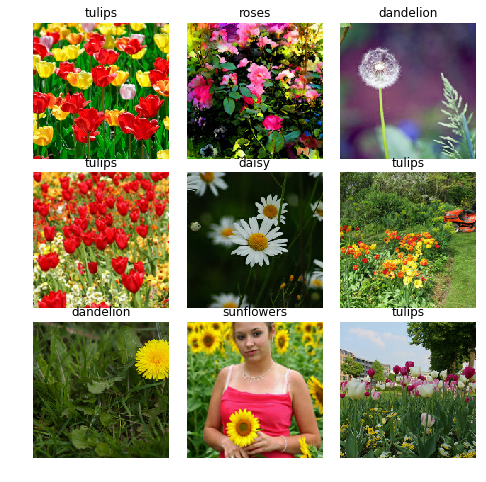

In [7]:
display_dataset = fds.dataset_from_tfr.map(lambda image, class_num: (image, class_num))
display_9_images_from_dataset(display_dataset, is_class_num=True, fds=fds)

In [8]:
len(list(fds.dataset_from_tfr.as_numpy_iterator()))

3670

So looks like all 3670 images are here - in `TFRecord` files in our bucket on `GCS`.

In [9]:
# so we have RGB images of specified size and 
for image, class_num in fds.dataset_from_tfr.take(1):
    print(image.shape, class_num)

(192, 192, 3) tf.Tensor(0, shape=(), dtype=int64)


## 3 - train / val / test split

In [49]:
fds = FlowersDataSet()

In [54]:
len(list(fds.val_ds.as_numpy_iterator())), 32 * 15

(15, 480)

In [55]:
len(list(fds.test_ds.as_numpy_iterator())), 32 * 7

(7, 224)

In [58]:
for image_batch, class_num_batch in fds.train_ds.take(1):
    print(image_batch.shape, image_batch[0].shape, class_num_batch[0])

(32, 192, 192, 3) (192, 192, 3) tf.Tensor(1, shape=(), dtype=int64)


In [64]:
ft = FlowersTrainer()

number of accelerators: 1


In [69]:
params.SPLITS

[2990, 460, 220]

In [70]:
ft.train_steps, ft.train_steps * params.BATCH_SIZE

(93, 2976)

In [71]:
ft.val_steps, ft.val_steps * params.BATCH_SIZE

(14, 448)

In [72]:
ft.test_steps, ft.test_steps * params.BATCH_SIZE

(6, 192)

## 4 - training

In [84]:
ft = FlowersTrainer()

number of accelerators: 1


In [74]:
ft.strategy

In [75]:
ft.weight_file, ft.history_file

(PosixPath('weights.h5'), PosixPath('history.pickle'))

In [76]:
for image_b, class_num_b in ft.train_ds.take(1):
    print(image_b.shape, image_b[0].shape, class_num_b[0])

(32, 192, 192, 3) (192, 192, 3) tf.Tensor(0, shape=(), dtype=int64)


In [78]:
ft.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 95, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 95, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 95, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [80]:
ft.train_steps, ft.val_steps, ft.test_steps

(93, 14, 6)

In [82]:
params.EPOCHS = 1
params.EPOCHS

1

Let's finally try to train.

In [88]:
ft = FlowersTrainer()

number of accelerators: 1


In [ ]:
ft.train()

## 5 - debugging dataset

In [99]:
ft = FlowersTrainer()

number of accelerators: 1


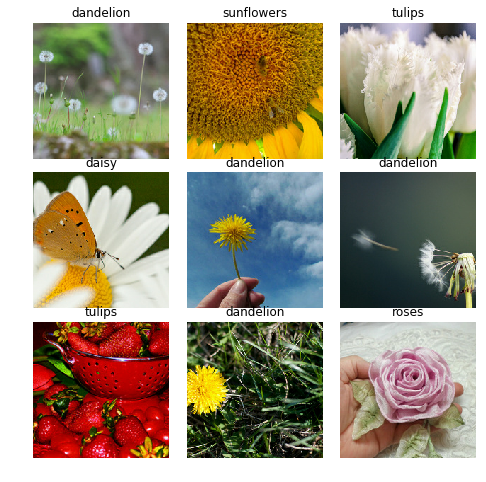

In [101]:
FlowerUtils.plot_sample_from_batch(ft.train_ds)

It turns out that results are much better when we use preprocessing function. Let's look in details how we read our dataset.